## Pre-requisites
Env: python 3.6, latest anaconda3 distribution  
Before running this notebook, make sure you have the following packages installed.
- kaggle api  
https://github.com/Kaggle/kaggle-api
- joblib  
conda install joblib  
Windows users are recommended to download and install the package directly from the github page https://github.com/joblib/joblib, as a Windows-specific bug was fixed in the recent master release but has not been pushed to conda repo yet.

## 2) Forecast the overnight stock price change direction

We want to forecast the direction of the overnight price change (between t0 close and t1 open prices) using the historical price and volume data. For instance, we use 01/05/2010's features as the training data and 01/06/2010's overnight price change direction as the training label to fit a model. Then we use 01/06/2010's features as the testing data and 01/07/2010's overnight price change direction as the testing label to evaluate the model. This process is repeated for all the dates available in the dataset. A trading strategy is formed using the model predictions that buys the stocks with predicted positive return at the market close price, and sell them the next day at the open price.  
  
We applied three models to explore the opportunity: random forest regressor, random forest classifer and and logistic regression. The random forest classifier model achieved the best results, however the precision rate is not good enough to form a profitable trading strategy.

In [1]:
import pandas as pd
import numpy as np
import talib
import os
import sys
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.finance as mpf
import random
from joblib import Parallel, delayed

%matplotlib inline

D:\Program_Files\Anaconda3\envs\stats\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### Download Kaggle datasets

In [2]:
# !kaggle datasets download -d dgawlik/nyse -p ./datasets

### Load the data

In [3]:
fundamentals = pd.read_csv("./datasets/fundamentals.csv", parse_dates=['Period Ending'])
prices = pd.read_csv("./datasets/prices.csv", parse_dates=['date'])
prices_adj = pd.read_csv("./datasets/prices-split-adjusted.csv", parse_dates=['date'])
securities = pd.read_csv("./datasets/securities.csv", parse_dates=['Date first added'])

In [4]:
symbols = sorted(prices_adj['symbol'].unique())
prices_adj.set_index(['symbol', 'date'], inplace=True, drop=True)
prices_adj.sort_index(inplace=True)

### Plotting

In [1]:
data = prices_adj.loc['BLK', ['open','close','high','low','volume']][:90]
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
mpf.candlestick2_ochl(ax, data['open'], data['close'], data['high'], data['low'], width=0.5, colorup='green', colordown='red', alpha=0.6)

NameError: name 'prices_adj' is not defined

### Normalize the prices entries using the t-1 close price  
- Effectively it's the daily return calculated as the difference of the log(price)  
- The price movement is modeled as a Wiener process (aka a random walk) in this analysis. Under this assumption,  
    - Return has normal distribution
    - Sometimes people use the Poisson process to model jumps, I stick with Wiener process for its simplicity.  
- Log transformation is performed to calculate the return  
    - Normally $return = (price_{t} - price_{t-1}) / price_{t-1}$, it can be approximate as $return = log(price_{t})-log(price_{t-1})$. 
    - The later can be more efficiently calculated, especially when calculating the cumulative.

In [6]:
ret = prices_adj.copy()

# Log transfrom the prices   
for col in ['open','close','low','high']:
    ret[col] = np.log(ret[col])
    
# Get the close price of the previous day
ret['close_m1'] = ret['close'].shift(1)

# Calculate normalize the prices using t-1 close price
ret.eval("""
            open = open - close_m1
            close = close - close_m1
            high = high - close_m1
            low = low - close_m1
         """,
             inplace = True)

# Drop close_m1
ret.drop(labels=['close_m1'], axis='columns', inplace=True)

# Drop the first entry for each ticker
idx = ret.groupby('symbol').head(1).index
ret.drop(labels=idx, axis='index', inplace=True)

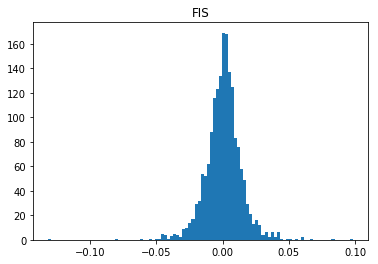

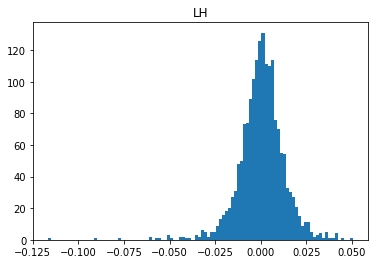

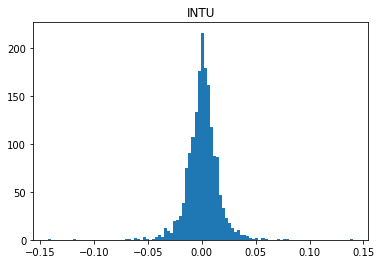

In [7]:
# The normal distribution assumption

for i in random.choices(symbols, k=3):
    plt.hist(ret.loc[i, 'close'], bins=100)
    plt.title(i)
    plt.show()

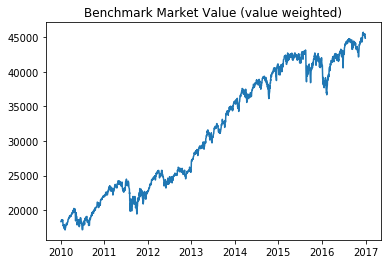

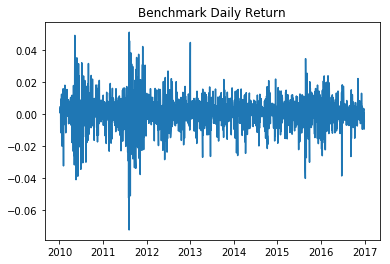

In [8]:
# Calculate the index return (baseline)

df = prices_adj.reset_index('symbol').sort_index()
bench = df.groupby(df.index)[['close']].sum()
plt.plot(bench)
plt.title("Benchmark Market Value (value weighted)")
plt.show()

bench_ret = np.log(bench) - np.log(bench.shift(1))
plt.plot(bench_ret)
plt.title("Benchmark Daily Return")
plt.show()

del(df)

In [9]:
# Calculate the daily active return (stock return - benchmark return)

ret = ret.swaplevel().sort_index()
ret['active'] = ret['close'] - bench_ret['close']

ret = ret.swaplevel().sort_index()

In [10]:
%%time
# Some feature engineering

def calc_features(symbol):
        
    df = ret.loc[[symbol]].copy()
        
    # Assign the daily return into buckets
#     df.loc[df['close']<=-0.05, 'ret_bucket_1'] = 1
#     df.loc[(df['close']>-0.05)&(df['close']<=-0.03), 'ret_bucket_2'] = 1
#     df.loc[(df['close']>-0.03)&(df['close']<=-0.01), 'ret_bucket_3'] = 1
#     df.loc[(df['close']>-0.01)&(df['close']<=0), 'ret_bucket_4'] = 1
#     df.loc[(df['close']>0)&(df['close']<=0.01), 'ret_bucket_5'] = 1
#     df.loc[(df['close']>0.01)&(df['close']<=0.03), 'ret_bucket_6'] = 1
#     df.loc[(df['close']>0.03)&(df['close']<=0.05), 'ret_bucket_7'] = 1
#     df.loc[df['close']>=0.05, 'ret_bucket_8'] = 1
#     df.fillna(0, axis=1, inplace=True)
    
    for period in [5, 10, 20, 30, 60, 90]:
        # Momentum (cumulative return of the previous n days)
        exec("""df['cum_ret_%s'] = df['close'].rolling(period).sum().values"""  % period)

        # Standard deviation
        exec("""df['std_%s'] = df['close'].rolling(period).std().values"""  % period)

        # relative volume (t0 : average over the period (t-n, t-1))
        exec("""df['vol_to_avg_%s'] = (df['volume'] / df['volume'].shift(1).rolling(period).mean()).values"""  % period)

        # relative volume (t0 : median over the period (t-n, t-1))
#         exec("""df['vol_to_med_%s'] = (df['volume'] / df['volume'].shift(1).rolling(period).median()).values"""  % period)

        # Highs and lows
        exec("""df['high_%s'] = df['high'].rolling(period).max().values"""  % period)
        exec("""df['low_%s'] = df['low'].rolling(period).min().values"""  % period)

    # Append previous 60 days' daily return
    for period in range(1, 61):
        exec("""df['close_t_m%s'] = df['close'].shift(period)"""  % period)
        exec("""df['open_t_m%s'] = df['open'].shift(period)"""  % period)
        exec("""df['high_t_m%s'] = df['high'].shift(period)"""  % period)
        exec("""df['low_t_m%s'] = df['low'].shift(period)"""  % period)
    
    return df

# Kick it off with multi threading
# out = Parallel(n_jobs=-1, backend="threading")(delayed(calc_features)(s) for s in symbols)

# If multi-threading is not working, run this instead
out = []
for s in symbols:
    out.append(calc_features(s))
    
    
features = pd.concat(out)
features.drop(['volume'], axis=1, inplace=True)
features = features.swaplevel().sort_index()
del(out)

Wall time: 1min 9s


### Define train and test data

Due to the nature of the panel data, the train and test data is splitted on a rolling basis. for example, during the training stage I use 01/05/2010's features as the X and 01/06/2010's return as the y to fit a model. To test this model, I need to use 01/06/2010's features as the test data and 01/07/2010's return as the test label to evaluate the model. This process is repeated for all the dates.

In [11]:
dates = features.reset_index()[['date']].drop_duplicates().reset_index(drop=True)
dates.rename_axis({'date': 'X_train'}, axis=1, inplace=True)
dates['y_train'] = dates['X_train'].shift(-1)
dates['X_test'] = dates['X_train'].shift(-1)
dates['y_test'] = dates['X_test'].shift(-1)
dates['trade_date'] = dates['X_test']
dates.set_index('trade_date', inplace=True)

dates.dropna(axis=0, inplace=True)

In [12]:
dates.head()

,X_train,y_train,X_test,y_test
trade_date,,,,
2010-01-06,2010-01-05,2010-01-06,2010-01-06,2010-01-07
2010-01-07,2010-01-06,2010-01-07,2010-01-07,2010-01-08
2010-01-08,2010-01-07,2010-01-08,2010-01-08,2010-01-11
2010-01-11,2010-01-08,2010-01-11,2010-01-11,2010-01-12
2010-01-12,2010-01-11,2010-01-12,2010-01-12,2010-01-13


In [13]:
dates.tail()

,X_train,y_train,X_test,y_test
trade_date,,,,
2016-12-22,2016-12-21,2016-12-22,2016-12-22,2016-12-23
2016-12-23,2016-12-22,2016-12-23,2016-12-23,2016-12-27
2016-12-27,2016-12-23,2016-12-27,2016-12-27,2016-12-28
2016-12-28,2016-12-27,2016-12-28,2016-12-28,2016-12-29
2016-12-29,2016-12-28,2016-12-29,2016-12-29,2016-12-30


In [14]:
def train_test_split(date):

    X_train = features.loc[dates.loc[date, 'X_train']].dropna(axis=0)
    y_train = features.loc[dates.loc[date, 'y_train'],'open'].dropna(axis=0)
    X_test = features.loc[dates.loc[date, 'X_test']].dropna(axis=0)
    y_test = features.loc[dates.loc[date, 'y_test'],'open'].dropna(axis=0)

    # Keep only the symbols that are in both sets
    X_train = X_train.loc[X_train.index.intersection(y_train.index)].sort_index()
    y_train = y_train.loc[y_train.index.intersection(X_train.index)].sort_index()
    X_test = X_test.loc[X_test.index.intersection(y_test.index)].sort_index()
    y_test = y_test.loc[y_test.index.intersection(X_test.index)].sort_index()

    # Make a binary y (1 for positive return, 0 for negative return)
    y_bin_train = (y_train > 0) * 1
    y_bin_test = (y_test > 0) * 1

    return X_train.as_matrix(), y_train.as_matrix(), y_bin_train.as_matrix(), X_test.as_matrix(), y_test.as_matrix(), y_bin_test.as_matrix()
#     return X_train, y_train, y_bin_train, X_test, y_test, y_bin_test

### Baseline
The baseline strategy trades all the stocks overnight (buy at t0 close, sell at t+1 open), equal weighted.

In [15]:
tmp = features.reset_index('symbol').loc[dates.index[90:], ['symbol', 'close']]

In [16]:
# Calculate the baseline daily return
baseline = []
for date in tmp.index.unique():
    baseline.append([date, tmp.loc[date,'close'].mean()])
    
baseline = np.array(baseline)

Text(0.5,1,'Baseline Cumulative Return')

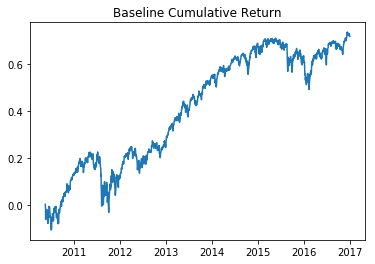

In [17]:
plt.plot(baseline[:,0], np.cumsum(baseline[:,1]))
plt.title("Baseline Cumulative Return")

### Random forest

#### Regressor

In [18]:
%%time

def evaluate_rf_regr(date):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    regr = RandomForestRegressor(n_estimators=20, random_state=1, n_jobs=1, bootstrap=True, criterion='mse')
    
    try:
        regr.fit(X_train, y_train)
    except ValueError:
        return [date, np.nan, np.nan]
        
    y_pred = regr.predict(X_test)
    
    # Calculate the accuracy of the direction prediction
    accu_d = sum(y_pred * y_test > 0) / len(y_test)
    
    # Create a long only strategy to equally buy the stock with predicted positive overnight return
    if len(y_test[y_pred > 0]) > 0:
        strat_return = np.mean(y_test[y_pred > 0])
    else:
        strat_return = 0
    return [date, accu_d, strat_return]



# Kick it off with multi-threading
# out = Parallel(n_jobs=-1, backend="threading")(delayed(evaluate_rf_regr)(date) for date in dates.index[90:])


# Try this if multi-threading did not work
out = []
for date in dates.index:
    out.append(evaluate_rf_regr(date))


result_rf_regr = np.array(out)

Wall time: 6min 56s


In [19]:
# Average accuracy for predicting direction
np.mean(result_rf_regr[:, 1])

0.47941881824309146

Text(0.5,1,'Return - Random Forest Regression')

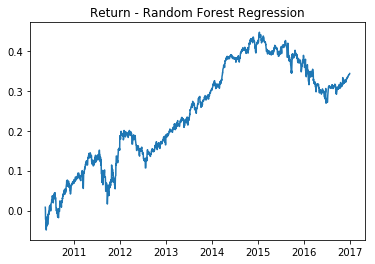

In [20]:
# Strategy cumulative return
plt.plot(result_rf_regr[:, 0], np.cumsum(result_rf_regr[:, 2]))
plt.title("Return - Random Forest Regression")

#### Classifier

In [21]:
%%time

def evaluate_rf_clf(date):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    clf = RandomForestClassifier(n_estimators=40, random_state=1, n_jobs=1, bootstrap=True, criterion="gini")

    try:
        clf.fit(X_train, y_bin_train)
    except ValueError:
        return [date, np.nan, np.nan, np.nan, np.nan, np.nan]
        
    y_pred = clf.predict(X_test)
    
    # Calculate the precision of the direction prediction
    if sum(y_pred==1) > 0:
        prec_up = sum((y_pred==1)&(y_bin_test==1)) / sum(y_pred==1)
    else:
        prec_up = np.nan
    
    if sum(y_pred==0) > 0:
        prec_down = sum((y_pred==0)&(y_bin_test==0)) / sum(y_pred==0)
    else:
        prec_down = np.nan
    
    # Calculate the accuracy of correct predictions in either directions
    accu = sum(y_pred + y_bin_test != 1) / len(y_pred)
    
    # Create a long only strategy to equally buy the stocks with predicted positive overnight return
    if len(y_test[y_pred == 1]) > 0:
        ret_long = np.mean(y_test[y_pred==1])
    else:
        ret_long = 0

    # Create a long-short strategy to buy the stocks with predicted positive overnight return and short the stocks with predicted negative return
    if len(y_test[y_pred == 0]) > 0:
        ret_short = -np.mean(y_test[y_pred==0])
    else:
        ret_short = 0
        
    ret_ls = ret_long + ret_short
        
        
    return [date, prec_up, prec_down, accu, ret_long, ret_ls]


# Run with multi-threading
# out = Parallel(n_jobs=-1, backend="threading")(delayed(evaluate_rf_clf)(date) for date in dates.index[90:])


# Try this if multi-threading did not work
out = []
for date in dates.index[90:]:
    out.append(evaluate_rf_clf(date))

result_rf_clf = np.array(out)
del(out)

Wall time: 4min 5s


In [22]:
## Average precision
# Up
print(np.nanmean(result_rf_clf[:, 1]))

# Down
print(np.nanmean(result_rf_clf[:, 2]))

## Average accuracy
print(np.nanmean(result_rf_clf[:, 3]))

0.5055734745764686
0.4943601561468758
0.4813630765559071


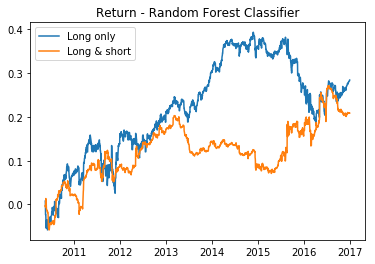

In [23]:
# Strategy cumulative return
plt.title("Return - Random Forest Classifier")
plt.plot(result_rf_clf[:, 0], np.cumsum(result_rf_clf[:, 4]))
plt.plot(result_rf_clf[:, 0], np.cumsum(result_rf_clf[:, 5]))
plt.legend(["Long only", "Long & short"])

### Logistic regression

In [24]:
%%time

def evaluate_log_reg(date, C):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    clf = LogisticRegression(penalty='l2', tol=0.0001, C=C)
    
    try:
        clf.fit(X_train, y_bin_train)
    except ValueError:
        return [date, np.nan, np.nan]

    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the direction prediction
    accu_d = sum(y_pred + y_bin_test != 1) / len(y_test)

    # Create a long only strategy to equally buy the stock with predicted positive overnight return
    if len(y_test[y_pred == 1]) > 0:
        strat_return = np.mean(y_test[y_pred == 1])
    else:
        strat_return = 0

    return [date, accu_d, strat_return]



# Find the best C value
max_accu = 0
C_max_accu = 0
max_ret = -1
C_max_ret = 0

for c in np.linspace(0.05, 1, 20):
#     out = Parallel(n_jobs=-1, backend="threading")(delayed(evaluate_log_reg)(date, c) for date in dates.index[90:])

    out = []
    for date in dates.index[90:]:
        out.append(evaluate_log_reg(date, c))
    
    result_log_reg = np.array(out)
    
    accu = np.nanmean(result_log_reg[:, 1])
    if accu > max_accu:
        max_accu = accu
        C_max_accu = c
        result_log_reg_max_accu = result_log_reg.copy()

    total_ret = np.nansum(result_log_reg[:, 2])
    if total_ret > max_ret:
        max_ret = total_ret
        C_max_ret = c
        result_log_reg_max_ret = result_log_reg.copy()
    
print(max_accu, C_max_accu, max_ret, C_max_ret)

0.4796234333118874 1.0 0.18952192202589 0.6
Wall time: 8min 16s


In [25]:
# Average accuracy for predicting direction
np.nanmean(result_log_reg[:, 1])

0.4796234333118874

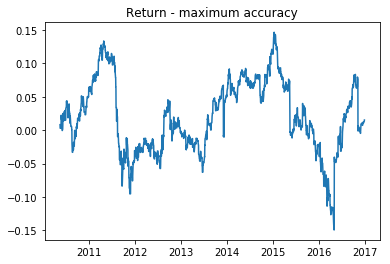

Text(0.5,1,'Return - maximum return')

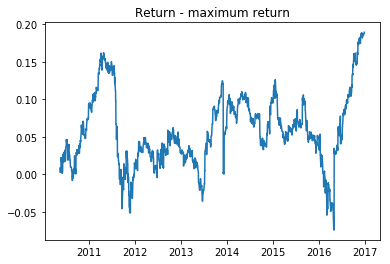

In [26]:
# Strategy cumulative return

# Maximum accuracy
plt.plot(result_log_reg_max_accu[:, 0], np.nancumsum(result_log_reg_max_accu[:, 2]))
plt.title("Return - maximum accuracy")
plt.show()

# Maximum return
plt.plot(result_log_reg_max_ret[:, 0], np.nancumsum(result_log_reg_max_ret[:, 2]))
plt.title("Return - maximum return")

## Summary
Predicting the short term stock price direction is extremely difficult and there are no state of the art researching work available (you do not want to share your results if you manage to come up with a competative strategy). Our best results yield a ~50% prediction precision, which is no better than randomly guessing. In the future development, we will try to impelment the similar approach to predict the mid-term (e.g. 20-day) price movement direction.